In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

import typing

## Functions and data

In [2]:

def plot_multiple_histories(histories : typing.Dict, metric='loss'):
  """
  Plots the training history of multiple models on the same plot for comparison.
  
  Parameters:
    histories: List of History objects from multiple model's fit() calls.
    metric: The metric to plot ('loss', 'accuracy', etc.).
    labels: List of labels for the models. If None, defaults to 'Model 1', 'Model 2', etc.
  """
  # Check if labels are provided, otherwise generate default labels
  # if labels is None:
  #   labels = [f'Model {i+1}' for i in range(len(histories))]
  
  # Initialize the plot
  plt.figure(figsize=(10, 6))
  
  # Loop through each history and plot the metrics
  for i, (label, history) in enumerate(histories.items()):
    epochs = range(1, len(history.history[metric]) + 1)
    
    # Plot training metric
    plt.plot(epochs, history.history[metric], label=f'{label} {metric.capitalize()}')
    
    # Plot validation metric if available
    if f'val_{metric}' in history.history:
      plt.plot(epochs, history.history[f'val_{metric}'], '--', label=f'{label} Validation {metric.capitalize()}')
  
  # Add labels and title
  plt.title(f'Comparison of {metric.capitalize()} Between Models')
  plt.xlabel('Epochs')
  plt.ylabel(metric.capitalize())
  plt.legend()
  
  # Show plot
  plt.show()



In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

X_r,y_r = make_regression(
  n_samples=5000,
  n_features=4,
  n_informative=3,
  noise=2
)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
  X_r,
  y_r,
  test_size=0.33,
  random_state=42
)

from sklearn.datasets import make_classification

X_c,y_c = make_classification(n_samples=1000, n_features=4, n_redundant=0)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_r, y_r, test_size=0.33, random_state=42)

## Learning Rate

In [4]:
def scheduler(epoch, lr, cutoff_epoch) -> float:
  if epoch < cutoff_epoch:
    return float(lr)
  else:
    return float(lr * tf.math.exp(-0.1))
  
callback = keras.callbacks.LearningRateScheduler(scheduler)

def train_model(callback) -> keras.callbacks.History:
  model = keras.models.Sequential()
  model.add(keras.layers.InputLayer(shape=(4,)))
  model.add(keras.layers.Dense(1))
  opt = keras.optimizers.SGD(learning_rate=0.001)
  model.compile(optimizer=opt, loss='mse', metrics=['mae'])
  history = model.fit(
    X_train_r, 
    y_train_r,
    batch_size=128, 
    epochs=100, 
    validation_split=0.3,
    callbacks=[callback]
  )
  return history



2024-10-09 10:35:25.541077: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-10-09 10:35:25.541118: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-10-09 10:35:25.541136: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-10-09 10:35:25.541160: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-09 10:35:25.541180: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100
 2/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15891.5869 - mae: 102.0229  

2024-10-09 10:35:25.914451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 15999.9570 - mae: 100.0304 - val_loss: 15841.1738 - val_mae: 100.2119 - learning_rate: 9.0484e-04
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14767.0293 - mae: 96.5143 - val_loss: 14911.1904 - val_mae: 97.2271 - learning_rate: 8.1873e-04
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14389.4219 - mae: 94.7471 - val_loss: 14116.2305 - val_mae: 94.6033 - learning_rate: 7.4082e-04
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13667.8848 - mae: 93.0653 - val_loss: 13430.9414 - val_mae: 92.2819 - learning_rate: 6.7032e-04
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12755.7607 - mae: 90.4236 - val_loss: 12845.6152 - val_mae: 90.2512 - learning_rate: 6.0653e-04
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12388.8936 - mae: 88.1546 - val_loss: 12332.6543 - val_mae: 88.4334 - learning_rate: 5.4881e-04
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11254.1133 - mae: 83

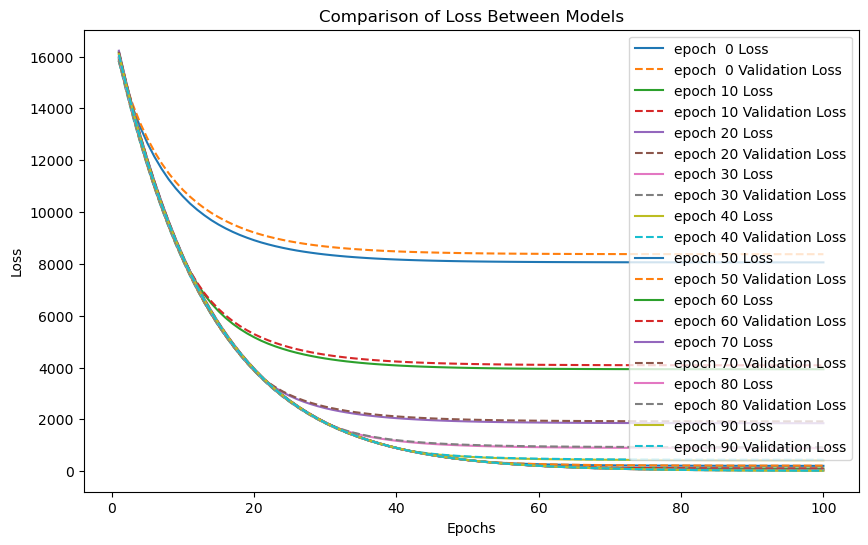

In [5]:
plot_multiple_histories(
  histories={
    f"epoch{i:3d}" : train_model(
      keras.callbacks.LearningRateScheduler(lambda e, lr : scheduler(e, lr, i))
    )
    for i in range(0, 100, 10)
  }
)

## Early Stopping

In [14]:

# This callback will stop the training when there is no improvement 
# in the validation loss for three consecutive epochs.
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=40)

model = keras.Sequential([keras.layers.Dense(10)])
model.compile(keras.optimizers.SGD(), loss='mse')
history = model.fit(
  np.arange(100).reshape(5, 20), 
  np.zeros(5),
  epochs=10, 
  batch_size=1, 
  callbacks=[callback]
)

len(history.history['loss'])  # Only 4 epochs are run.


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3211675343781888.0000
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11684803378271129445167817730031616.0000
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: inf 
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: inf
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan


10

## Weight Regularization

In [7]:

from sklearn.datasets import make_classification

X,y = make_classification(n_samples=1000, n_features=4, n_redundant=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [8]:


def train_model_regular(regularizer_rate=1.0) -> keras.callbacks.History:
  model = keras.models.Sequential()
  model.add(keras.Input(shape=(4,)))
  model.add(keras.layers.Dense(10))
  model.add(
    keras.layers.Dense(
      10,
      kernel_regularizer=keras.regularizers.l2(regularizer_rate)
    )
  )
  model.add(keras.layers.Dense(1, activation='sigmoid'))
  
  model.compile(
    optimizer='SGD',
    loss='binary_crossentropy',
    metrics=['accuracy']
  )
  history = model.fit(
    X_train, 
    y_train,
    batch_size=32, 
    epochs=40, 
    validation_split=0.3
  )
  
  return history



Epoch 1/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6969 - loss: 0.6497 - val_accuracy: 0.7624 - val_loss: 0.5247
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7273 - loss: 0.5584 - val_accuracy: 0.7822 - val_loss: 0.4687
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7883 - loss: 0.4515 - val_accuracy: 0.8168 - val_loss: 0.4375
Epoch 4/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8329 - loss: 0.4333 - val_accuracy: 0.8366 - val_loss: 0.4182
Epoch 5/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8227 - loss: 0.4023 - val_accuracy: 0.8465 - val_loss: 0.4047
Epoch 6/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8345 - loss: 0.4171 - val_accuracy: 0.8614 - val_loss: 0.3953
Epoch 7/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8394 - loss: 0.3786 - val_accuracy: 0.8614 - val_loss: 0.3884
Epoch 8/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8444 - loss: 0.3750 - val_accuracy: 0.8614 - val_loss

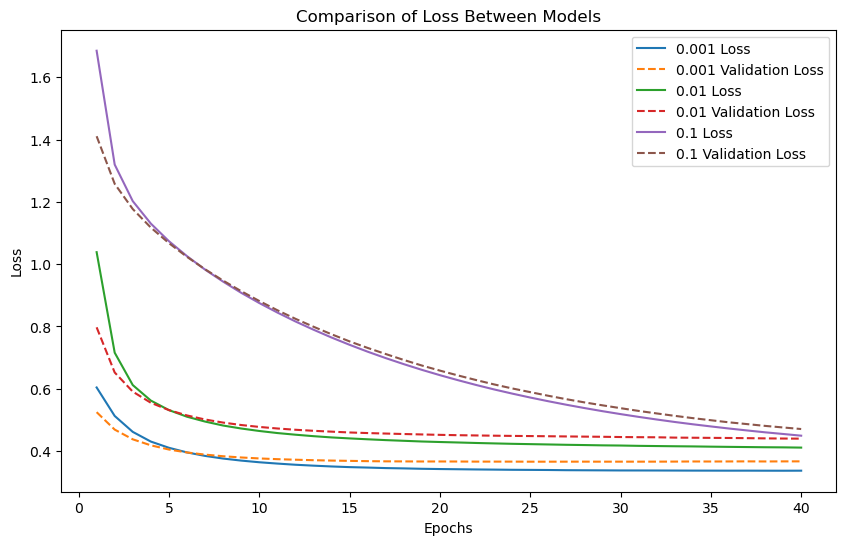

In [9]:
plot_multiple_histories(
  histories={
    "0.001" : train_model_regular(0.001),
    "0.01" : train_model_regular(0.01),
    "0.1" : train_model_regular(0.1),
  }
)

## Dropout


In [10]:


def train_model_dropout(dropout_rate) -> keras.callbacks.History:
  model = keras.models.Sequential()
  model.add(keras.Input(shape=(4,)))
  model.add(keras.layers.Dropout(dropout_rate))
  model.add(keras.layers.Dense(10))
  model.add(keras.layers.Dropout(dropout_rate))
  model.add(keras.layers.Dense(1, activation='sigmoid'))
  
  model.compile(
    optimizer='SGD',
    loss='binary_crossentropy',
    metrics=['accuracy']
  )
  history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=40,
    validation_split=0.3
  )
  
  return history


Epoch 1/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3852 - loss: 1.1353 - val_accuracy: 0.4505 - val_loss: 0.8111
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4981 - loss: 0.8185 - val_accuracy: 0.5842 - val_loss: 0.6798
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6131 - loss: 0.6766 - val_accuracy: 0.6733 - val_loss: 0.6169
Epoch 4/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6623 - loss: 0.6144 - val_accuracy: 0.7228 - val_loss: 0.5805
Epoch 5/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6861 - loss: 0.5788 - val_accuracy: 0.7475 - val_loss: 0.5562
Epoch 6/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7017 - loss: 0.5813 - val_accuracy: 0.7624 - val_loss: 0.5381
Epoch 7/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7454 - loss: 0.5166 - val_accuracy: 0.7673 - val_loss: 0.5234
Epoch 8/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7110 - loss: 0.5375 - val_accuracy: 0.7673 - val_loss

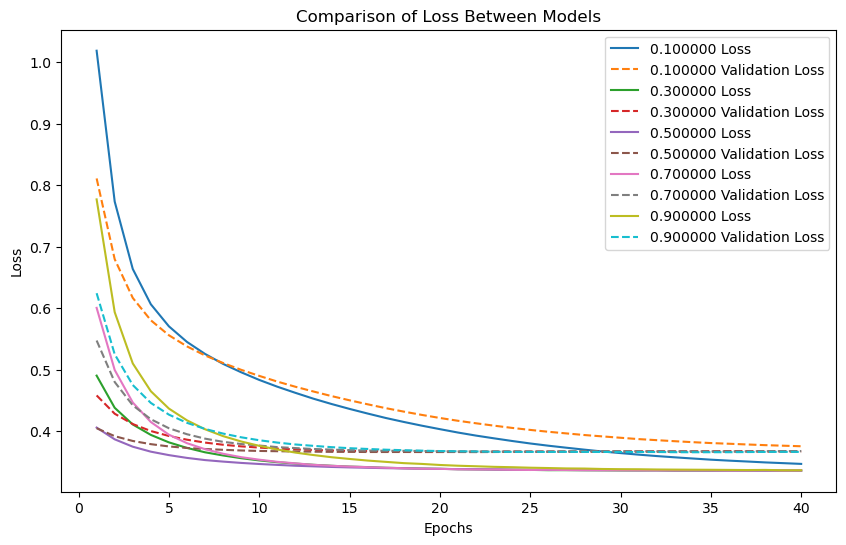

In [11]:
plot_multiple_histories(
  histories={
    f"{val:f}" : train_model_regular(0.001)
    for val in np.arange(0.1, 1.01, 0.2)
  }
)